In [2]:
import pandas as pd
import os
import numpy as np
from util import plot_cdf

In [3]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [5]:
worst_low_id=0
res_dir=f'../res/{worst_low_id}'
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

if not os.path.exists(f'{res_dir}/{worst_low_id}/size_ns3.npy'):
    np.random.seed(1)
    N_FLOWS=500*100*4
    N_FLOW_THRESHOLD = [1, 1, 1, 1]
    mlsys_dir="mlsys"
    mix_dir = f'../data/{worst_low_id}'
    # Accuracy metrics
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3-config/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_mlsys = [[] for _ in range(n_size_bucket_list_output)]

    n_freq_list=[]
    n_flow_list=[]
    sizes=df_pmn_m['size']

    path_idx=0
    while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
        with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
            lines = file.readlines()
            data=lines[0].strip().split(",")
            n_freq_list.append(int(data[-1]))
            
            flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
            size_list=[sizes[flowid] for flowid in flowid_list]
            
            n_links=len(data[0].split("|"))-1
            tmp=np.digitize(size_list, bin_size_list)
            # Count occurrences of each bin index
            bin_counts = np.zeros(n_size_bucket_list_output)
            for bin_idx in tmp:
                bin_counts[bin_idx]+=1
            n_flow_list.append(bin_counts)
        path_idx+=1
    n_flow_list=np.array(n_flow_list)
    n_flow_list_sum=n_flow_list.sum(axis=0)

    with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
        lines = file.readlines()
        lines=lines[1:]
        for line_idx,line in enumerate(lines):
            data=line.strip().split(",")
            data = [float(value) for value in data]
            n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
            
            if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]>=N_FLOW_THRESHOLD[line_idx%n_size_bucket_list_output]:
                for _ in range(n_freq):
                    df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
    df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
    bucket_ratios_sampled=n_flow_list_sum/sum(n_flow_list_sum)
    print("bucket_ratios_sampled: ",bucket_ratios_sampled)
                
    df_mlsys_bucket=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
    print("df_mlsys_bucket: ",df_mlsys_bucket)
    df_mlsys_total=[]
    for i in range(len(df_mlsys)):
        n_tmp=int(N_FLOWS*bucket_ratios_sampled[i])
        df_mlsys_total.extend(np.random.choice(df_mlsys[i],n_tmp,replace=True))
    df_mlsys_p99=np.percentile(df_mlsys_total,99)

    sldn_ns3=df_ns3['slowdown']
    sldn_pmn_m=df_pmn_m['slowdown']
    size_ns3=df_ns3['size']
    size_pmn_m=df_pmn_m['size']
    
    # randomly sample N_FLOWS flows for reproducibility
    idx_ns3 = np.random.choice(len(sldn_ns3), N_FLOWS, replace=False)
    size_ns3=size_ns3[idx_ns3]
    sldn_ns3=sldn_ns3[idx_ns3]
    idx_pmn=np.random.choice(len(sldn_pmn_m), N_FLOWS, replace=False)
    size_pmn_m=size_pmn_m[idx_pmn]
    sldn_pmn_m=sldn_pmn_m[idx_pmn]
    
    np.save(f'{res_dir}/size_ns3.npy',size_ns3)
    np.save(f'{res_dir}/size_pmn_m.npy',size_pmn_m)
    np.save(f'{res_dir}/sldn_ns3.npy',sldn_ns3)
    np.save(f'{res_dir}/sldn_pmn_m.npy',sldn_pmn_m)
    np.save(f'{res_dir}/sldn_mlsys.npy', np.array(df_mlsys, dtype=object), allow_pickle=True)
else:
    size_ns3=np.load(f'{res_dir}/size_ns3.npy')
    size_pmn_m=np.load(f'{res_dir}/size_pmn_m.npy')
    sldn_ns3=np.load(f'{res_dir}/sldn_ns3.npy')
    sldn_pmn_m=np.load(f'{res_dir}/sldn_pmn_m.npy')
    df_mlsys=np.load(f'{res_dir}/sldn_mlsys.npy', allow_pickle=True).tolist()
    
    
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," df_mlsys: ", df_mlsys_p99)
error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
error_mlsys=(df_mlsys_p99-sldn_ns3_p99)/sldn_ns3_p99

bucket_ratios_sampled:  [0.34416826 0.45315488 0.10133843 0.10133843]
df_mlsys_bucket:  [1.590548   1.39235038 2.353723   3.100757  ]
sldn_ns3:  2.0426189237276238  sldn_pmn_m:  4.284432339999517  df_mlsys:  2.0967994800000165


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


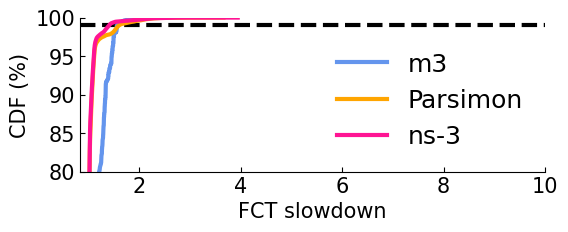

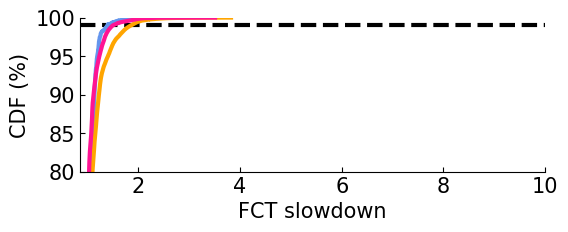

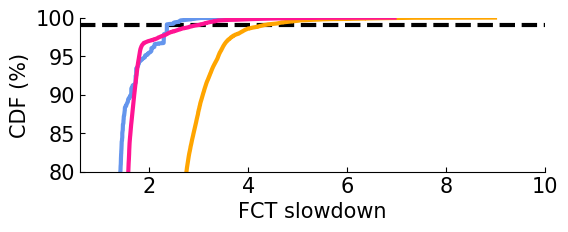

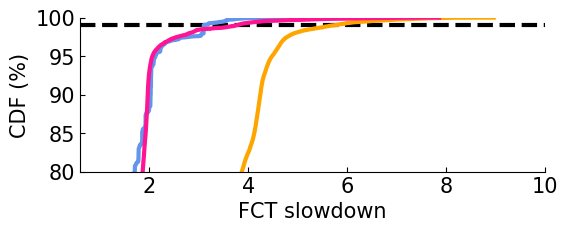

In [6]:
legend_list=['m3','Parsimon','ns-3']
bin_ns3=np.digitize(size_ns3, bin_size_list)
bin_pmn_m=np.digitize(size_pmn_m, bin_size_list)
x_lim_list=[10,10,10,10]
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn_m==i, sldn_pmn_m)
    tmp_sldn_mlsys=np.array(df_mlsys[i])
    
    plot_data=[tmp_sldn_mlsys,tmp_sldn_pmn_m,tmp_sldn_ns3]
    plot_cdf(plot_data,f'figs/eva_large_scale_{i}.pdf',legend_list if i==0 else [],'FCT slowdown',legend_font=18,group_size=3,loc=4,rotate_xaxis=False,ylim_low=80,log_switch=False,xlim=x_lim_list[i])
    